In [167]:
import numpy as np
import pickle
import time
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

In [243]:
input_file_name = 'FNAL2024/WScFi10GeV28degrees.txt'
output_file_name = 'Data/WScFi10GeV28degreesraw.pkl'
output_file_name_ped = 'Data/WScFi10GeV28degreesped.pkl'

257


<ErrorbarContainer object of 3 artists>

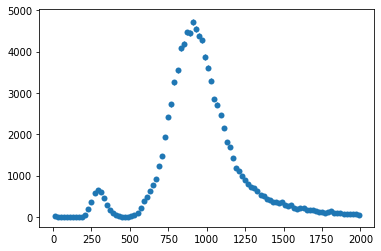

In [244]:
# Read the text file
df = pd.read_csv(input_file_name, delimiter='\t', header=None)

# Assign column names
column_names = ['event_id'] + [f'ch_{i-1}' for i in range(1, len(df.columns))]
df.columns = column_names

# Split dataframe into different detectors

sc1_df = df[['event_id', 'ch_32']]
sc2_df = df[['event_id', 'ch_40']]#
mon_df = df[['event_id', 'ch_33']]#
pbg_df = df[['event_id', 'ch_34']]
ce1_df = df[['event_id', 'ch_35']]#
ce2_df = df[['event_id', 'ch_37']]
veto1_df = df[['event_id', 'ch_38']]#
veto2_df = df[['event_id', 'ch_39']]#

# Define channel lists based on C script configuration
HCalChannelList = list(range(16))
ECalChannelList = [i + 16 for i in range(16)]
HodChannelList = [i + 48 for i in range(16)]

# Split dataframe into different detectors using the channel lists
hcal_df = df[['event_id'] + [f'ch_{i}' for i in HCalChannelList]]
ecal_df = df[['event_id'] + [f'ch_{i}' for i in ECalChannelList]]
hod_df = df[['event_id'] + [f'ch_{i}' for i in HodChannelList]]

# Combine dataframes into a dictionary
dataframes_dict = {
    'hcal_df': hcal_df,
    'ecal_df': ecal_df,
    'sc1_df': sc1_df,
    'sc2_df': sc2_df,
    'pbg_df': pbg_df,
    'mon_df': mon_df,
    'ce1_df': ce1_df,
    'ce2_df': ce2_df,
    'veto1_df': veto1_df,
    'veto2_df': veto2_df,
    'hod_df': hod_df
}

# Identify indices to remove
indices_to_remove = set()

# Iterate through each dataframe and find indices with value 5632 or 16384
for df_key, df in dataframes_dict.items():
    for col in df.columns:
        if col != 'event_id':
            indices_to_remove.update(df[(df[col] == 5632) | (df[col] == 16384)].index)

# Remove identified indices from all dataframes
for df_key in dataframes_dict:
    dataframes_dict[df_key] = dataframes_dict[df_key].drop(indices_to_remove).reset_index(drop=True)
print(len(indices_to_remove))

h, bins = np.histogram(dataframes_dict['sc1_df'], bins=100, range=(0, 2000))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)

In [245]:
cutoff = 500


pedestals_dict = dataframes_dict.copy()
indices_to_remove = set()
for df_key, df in pedestals_dict.items():
    for col in df.columns:
        if col == 'ch_32':
            indices_to_remove.update(df[(df[col] >= cutoff)].index)
for df_key in pedestals_dict:
    pedestals_dict[df_key] = pedestals_dict[df_key].drop(indices_to_remove).reset_index(drop=True)
# Save dictionary as pickle file

with open(output_file_name_ped, 'wb') as file:
    pickle.dump(pedestals_dict, file)
    
    

indices_to_remove = set()
for df_key, df in dataframes_dict.items():
    for col in df.columns:
        if col == 'ch_32':
            indices_to_remove.update(df[(df[col] < cutoff)].index)
for df_key in dataframes_dict:
    dataframes_dict[df_key] = dataframes_dict[df_key].drop(indices_to_remove).reset_index(drop=True)
# Save dictionary as pickle file

with open(output_file_name, 'wb') as file:
    pickle.dump(dataframes_dict, file)